In [ ]:
# 라이브러리 불러오기
!pip install koreanize_matplotlib -q

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import koreanize_matplotlib
import warnings
import seaborn as sns

warnings.simplefilter(action='ignore')

%config InlineBackend.figure_format = 'retina'

In [35]:
path7 = 'C:/Users/user/.ipython/data/log_2022.csv'
log22 = pd.read_csv(path7, index_col=0)
log22.tail()

user_uuid  \
10054119  d2b90cda-7e0d-454f-8a64-070048551e14   
10054120  5ddc8a26-b006-4f26-b576-08095d22cf8a   
10054121  f9387b22-2d7d-4267-8671-2279e2d784b9   
10054122  849ff1bb-6280-46f4-baaa-71d1d0796b5b   
10054123  940b883f-a385-416c-94e2-b5604a78506c   

                                                        URL  \
10054119  setting?utm_source=notification&utm_medium=ema...   
10054120                                   jobs/id/id_title   
10054121                                           @user_id   
10054122                                                NaN   
10054123                              api/companies/id/view   

                               timestamp        date  response_code method  
10054119  2022-07-28 00:34:34.781394 UTC  2022-07-28            200    GET  
10054120   2022-04-06 03:28:19.99548 UTC  2022-04-06            200    GET  
10054121  2022-11-14 12:11:53.841597 UTC  2022-11-14            200    GET  
10054122  2022-02-10 05:58:29.778388 UTC  2022-02-10            200    GET  
10054123  2022-02-03 02:54:20.404898 UTC  2022-02-03            200   POST

In [36]:
path8 = 'C:/Users/user/.ipython/data/log_2023.csv'
log23 = pd.read_csv(path8, index_col=0)
log23.tail()

user_uuid  \
7187778  167cdb14-d145-4679-b878-66a9a2d32ee9   
7187779  167cdb14-d145-4679-b878-66a9a2d32ee9   
7187780  f5649d90-3016-4747-9924-a05d74ee895e   
7187781  f5649d90-3016-4747-9924-a05d74ee895e   
7187782  f5649d90-3016-4747-9924-a05d74ee895e   

                                        URL                       timestamp  \
7187778                            @user_id  2023-11-14 12:12:26.780872 UTC   
7187779                            @user_id  2023-11-14 12:11:38.859562 UTC   
7187780               api/users/id/template  2023-11-14 13:16:19.471324 UTC   
7187781  verify_phone?next_url=/%40kkwangpe  2023-11-14 13:16:11.530244 UTC   
7187782                            @user_id  2023-11-14 13:16:18.579935 UTC   

               date  response_code method  
7187778  2023-11-14            200    GET  
7187779  2023-11-14            200    GET  
7187780  2023-11-14            200   POST  
7187781  2023-11-14            200    GET  
7187782  2023-11-14            200    GET

In [37]:
# 데이터타입 변경
log22['date'] = pd.to_datetime(log22['date'])
log23['date'] = pd.to_datetime(log23['date'])

log22['month'] = log22['date'].dt.month
log23['month'] = log23['date'].dt.month

# sort_log
log = pd.concat([log22, log23])
sort_log = log.sort_values(['user_uuid', 'timestamp'])

# 연-월 컬럼 생성
log['date'] = pd.to_datetime(log['date'])
log['y_month']= log['date'].dt.strftime('%Y-%m')

# sort_log 개수, NULL값 확인,  NULL값 비율 확인
print(f"전체 log 수 : {len(sort_log['URL'])}")
print(f"-" * 50)
print(f"NULL 개수 : {sort_log.isnull().sum()}")
print(f"-" * 50)
print(f"NULL 비율 {sort_log.isnull().sum() / len(sort_log['URL']) * 100} %")

# NULL제거
sort_log = sort_log.dropna()
print(f"sort_log 개수 : {len(sort_log)}")

# sort_log / response 처리
sort_log = sort_log[sort_log['response_code'].isin([200, 301, 302])]
print(f"비정상적으로 서버요청 된 url 수 : {16597751 - len(sort_log)}")
print(f"비정상적으로 서버요청 된 url 비율 : {((16597751 - len(sort_log)) / 16597751) * 100} %")

print(f"제거 후 log 수 : {len(sort_log)}")

# sort_log / UTC → 한국시간대로 변경
sort_log['timestamp'] = sort_log['timestamp'].str.replace(' UTC', '',regex=False)
sort_log['timestamp'] = pd.to_datetime(sort_log['timestamp'], utc=True, format='mixed')
sort_log['timestamp'] = sort_log['timestamp'].dt.tz_convert('Asia/Seoul')

# sort_log / 세션 추가
sort_log['prev_time'] = sort_log.groupby('user_uuid')['timestamp'].shift(1)  # 전행수
sort_log['time_diff'] = (sort_log['timestamp'] - sort_log['prev_time']).dt.total_seconds()  # 초단위

# 1시간(3600초) 이상 or 시간차가 없으면(유저 구분) 새로운 새션 생성 (1 or 0)
sort_log['new_session'] = (sort_log['time_diff'] > 3600) | (sort_log['time_diff'].isna()) 

# 세션에서 순서 지정
sort_log['session_id'] = sort_log.groupby('user_uuid')['new_session'].cumsum()

# 기술적 통계를 살펴보고 새로운 세션의 기준 시간을 설정함
print(f" 세션 공백 시간 기술통계 : {round(sort_log['time_diff'].describe() / 60, 2)}")
print('-' * 50)
print(f" 세션 id 기술적 통계 : {round(sort_log['session_id'].describe(), 2)}")

전체 log 수 : 17241907
--------------------------------------------------
NULL 개수 : user_uuid             0
URL              644156
timestamp             0
date                  0
response_code         0
method                0
month                 0
dtype: int64
--------------------------------------------------
NULL 비율 user_uuid        0.00000
URL              3.73599
timestamp        0.00000
date             0.00000
response_code    0.00000
method           0.00000
month            0.00000
dtype: float64 %
sort_log 개수 : 16597751
비정상적으로 서버요청 된 url 수 : 127605
비정상적으로 서버요청 된 url 비율 : 0.7688089789996246 %
제거 후 log 수 : 16470146
 세션 공백 시간 기술통계 : count     274146.77
mean         560.55
std         9978.47
min            0.00
25%            0.01
50%            0.04
75%            0.22
max      1017032.31
Name: time_diff, dtype: float64
--------------------------------------------------
 세션 id 기술적 통계 : count    16470146.00
mean           66.46
std           117.54
min             1.00
25%      

In [38]:
sort_log_URL_count = sort_log.groupby('user_uuid')['URL'].count().reset_index()

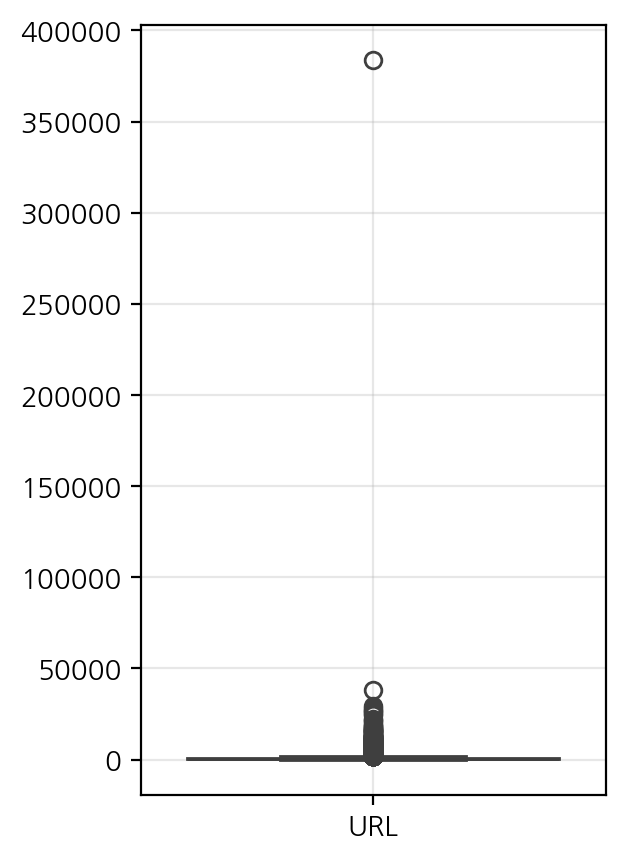

In [39]:
plt.figure(figsize=(3,5))
sns.boxplot(data= sort_log_URL_count)
plt.grid(alpha=0.3)
plt.xticks()
plt.show()

In [40]:
from scipy.stats import zscore

zs = np.abs(zscore(sort_log_URL_count['URL']))
fiter_mask = zs < 3
zscore_clean = sort_log_URL_count[fiter_mask]

In [41]:
print(f" 제거 전 유저 수 : {sort_log_URL_count['user_uuid'].nunique()}")
print(f" 제거 후 유저 수 : {zscore_clean['user_uuid'].nunique()}")
print(f" 제거 된 유저수 : {sort_log_URL_count['user_uuid'].nunique() - zscore_clean['user_uuid'].nunique()}")

 제거 전 유저 수 : 21340
 제거 후 유저 수 : 21257
 제거 된 유저수 : 83


In [42]:
log_session_count = pd.merge(sort_log_URL_count, sort_log.groupby('user_uuid')['session_id'].max(), how='inner', on='user_uuid')
log_session_count['URL_sessionse'] = log_session_count['URL'] / log_session_count['session_id']
log_session_count

user_uuid   URL  session_id  URL_sessionse
0      0002535c-eacb-456b-a620-92c917332ba3   213          23       9.260870
1      0005769f-54b1-44ab-b6d3-bd9147c006a8     5           2       2.500000
2      000681b4-bb66-4ccf-9786-f0066d13a34e   214           2     107.000000
3      000b55ad-5c86-438b-a5b0-9ea3a2917789   681          45      15.133333
4      000d53f7-5ddd-48ba-8dab-bb77b157e13a    87           4      21.750000
...                                     ...   ...         ...            ...
21335  fff082bd-c063-4d10-be2d-b2b53f54527e    42           1      42.000000
21336  fff3440e-7c0a-485b-a392-c41023060e96   308          14      22.000000
21337  fff45252-3c40-4805-99e9-6b650c1fca80   235          20      11.750000
21338  fff8a5c0-c85b-4e30-a22d-ed61b4480615   335           9      37.222222
21339  ffff25ca-c1d7-4fc2-891b-b0df92f95092  1628          86      18.930233

[21340 rows x 4 columns]

In [43]:
len(sort_log)

16470146

<Axes: ylabel='URL_sessionse'>

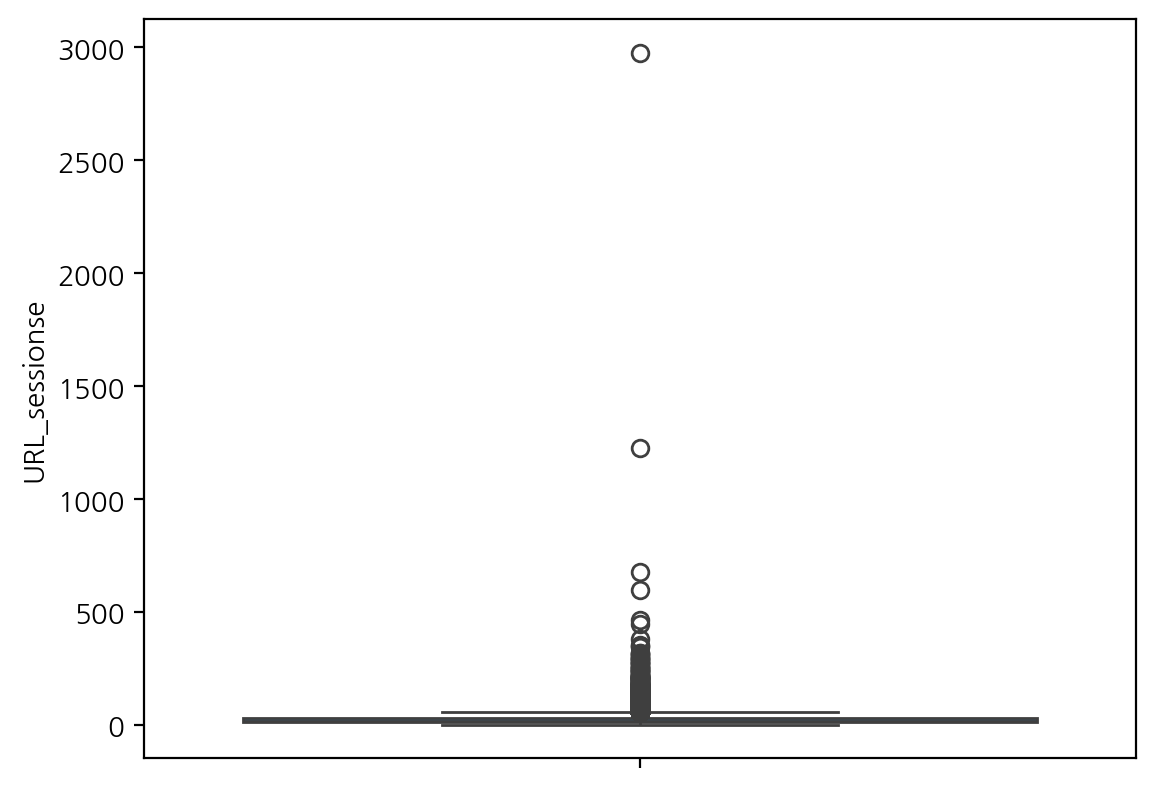

In [44]:
sns.boxplot(log_session_count['URL_sessionse'])

<Axes: ylabel='URL_sessionse'>

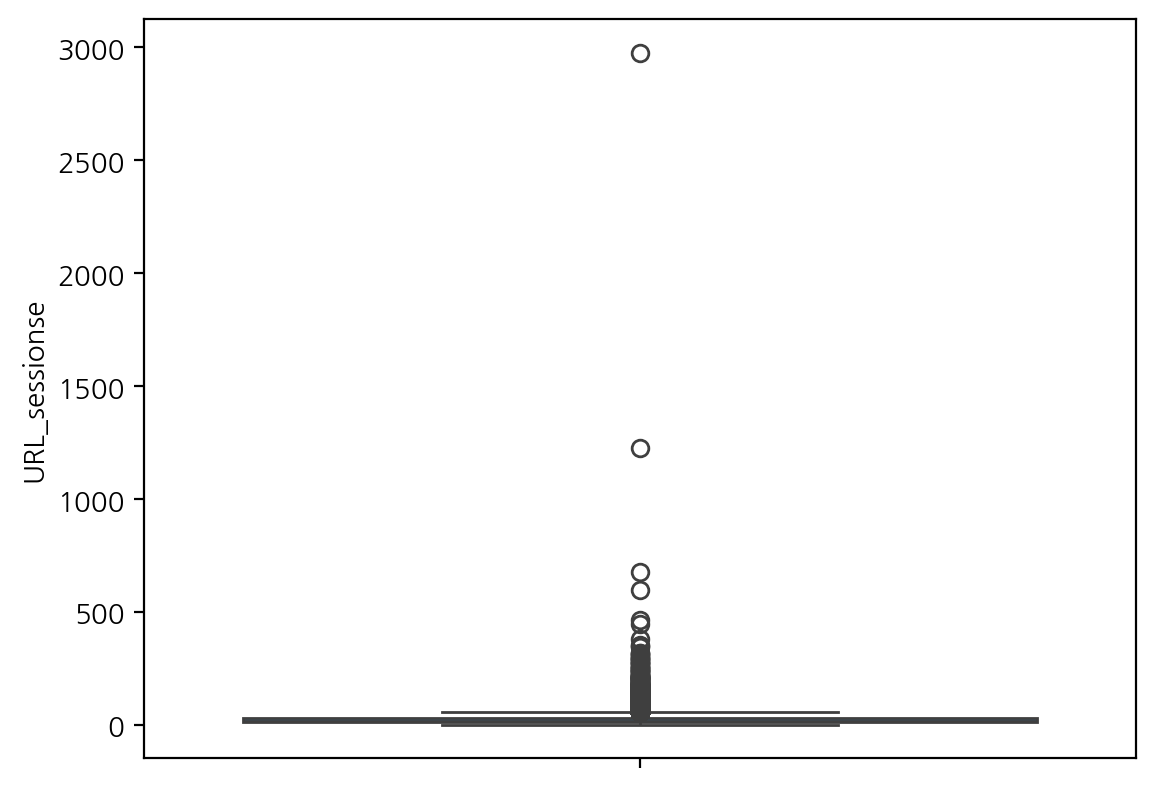

In [45]:
sns.boxplot(log_session_count['URL_sessionse'])

In [46]:
from scipy.stats import zscore

zs = np.abs(zscore(log_session_count['URL_sessionse']))
fiter_mask = zs < 3
zscore_clean = log_session_count[fiter_mask]


print(log_session_count['user_uuid'].nunique())
print(zscore_clean['user_uuid'].nunique())
print(log_session_count['user_uuid'].nunique() -zscore_clean['user_uuid'].nunique())

21340
21094
246


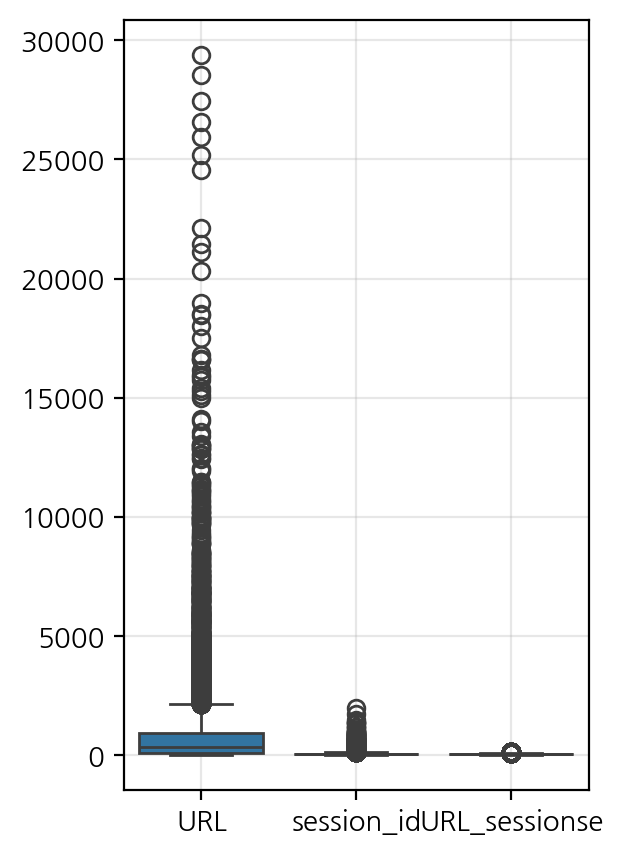

In [20]:
plt.figure(figsize=(3,5))
sns.boxplot(data= zscore_clean)
plt.grid(alpha=0.3)
plt.xticks()
plt.show()

In [28]:
zscore_clean

user_uuid   URL  session_id  URL_sessionse
0      0002535c-eacb-456b-a620-92c917332ba3   213          23       9.260870
1      0005769f-54b1-44ab-b6d3-bd9147c006a8     5           2       2.500000
2      000681b4-bb66-4ccf-9786-f0066d13a34e   214           2     107.000000
3      000b55ad-5c86-438b-a5b0-9ea3a2917789   681          45      15.133333
4      000d53f7-5ddd-48ba-8dab-bb77b157e13a    87           4      21.750000
...                                     ...   ...         ...            ...
21335  fff082bd-c063-4d10-be2d-b2b53f54527e    42           1      42.000000
21336  fff3440e-7c0a-485b-a392-c41023060e96   308          14      22.000000
21337  fff45252-3c40-4805-99e9-6b650c1fca80   235          20      11.750000
21338  fff8a5c0-c85b-4e30-a22d-ed61b4480615   335           9      37.222222
21339  ffff25ca-c1d7-4fc2-891b-b0df92f95092  1628          86      18.930233

[21094 rows x 4 columns]

In [21]:
print(f" 제거 전 유저 수 : {sort_log_URL_count['user_uuid'].nunique()}")
print(f" 제거 후 유저 수 : {zscore_clean['user_uuid'].nunique()}")
print(f" 제거 된 유저수 : {sort_log_URL_count['user_uuid'].nunique() - zscore_clean['user_uuid'].nunique()}")

 제거 전 유저 수 : 21340
 제거 후 유저 수 : 21094
 제거 된 유저수 : 246


In [16]:
from scipy.stats import zscore

zs = np.abs(zscore(sort_log_URL_count['URL']))
fiter_mask = zs < 3
zscore_clean = sort_log_URL_count[fiter_mask]

In [6]:
# 'apply'가 포함된 URL 중에서 '?' 뒤에 'apply'가 포함된 경우 필터링

def apply_after_question_mark(url):
    if pd.isna(url):
        return False
    parts = url.split('?', 1)
    # '?' 뒤 부분이 있고, 그 부분에 'apply' 포함 여부 검사
    return len(parts) == 2 and 'apply' in parts[1]

# 필터링
filtered_df = sort_log[sort_log['URL'].apply(apply_after_question_mark)]

# 개수 출력
print(len(filtered_df))

# URL에서 쿼리 파라미터 제거 및 정리
sort_log[['cleaned_URL', 'query_params']] = sort_log['URL'].str.split('?', expand=True)

# 명사 추출 함수
def extract_nouns(url):
    okt = Okt()
    # URL에서 '/'를 기준으로 분리하고, 각 부분에서 명사 추출
    nouns = []
    for part in url.split('/'):
        nouns.extend(okt.nouns(part))
    return ' '.join(nouns)

348893


In [ ]:
def classify_action(cleaned_URL, method=None):

    # 1. 결측값 및 문자열 정제
    if pd.isna(cleaned_URL):
        return '빈 URL'

    cleaned_URL = str(cleaned_URL).lower().strip()
    if cleaned_URL == '':
        return '빈 URL'

    # 2. method 정제 (대소문자, 공백 포함 가능성 대응)
    if method:
        method = str(method).strip().lower()

    # 3. 회원가입 관련
    if 'signup' in cleaned_URL and 'done' in cleaned_URL:
        return '회원가입완료'
    elif 'signup' in cleaned_URL:
        return '회원가입 페이지 진입'

    # 4. 지원 흐름 상세 구분
    if 'apply_progress' in cleaned_URL:
        return '지원 진행 상태 확인'
    elif 'application' in cleaned_URL or 'resume' in cleaned_URL:
        return '지원서 업데이트'
    elif 'apply' in cleaned_URL and 'step4' in cleaned_URL:
        if method == 'post':
            return '지원서 작성 - 제출 완료'
        else:
            return '지원서 작성 - step4'
    elif 'apply' in cleaned_URL and 'step3' in cleaned_URL:
        return '지원서 작성 - step3'
    elif 'apply' in cleaned_URL and 'step2' in cleaned_URL:
        return '지원서 작성 - step2'
    elif 'apply' in cleaned_URL and 'step1' in cleaned_URL:
        return '지원서 작성 - step1'
    elif 'apply' in cleaned_URL:
        return '지원서 작성 - 페이지 진입'
    
    # 5. 채용 관련
    if 'job' in cleaned_URL and 'bookmark' in cleaned_URL:
        return '채용공고 북마크'
    elif 'job' in cleaned_URL or 'recruit' in cleaned_URL:
        return '채용정보 조회'
    elif ('companies' in cleaned_URL or 'company'in cleaned_URL) and 'member' in cleaned_URL:
        return '기업 구성원 프로필 조회'
    elif (('companies' in cleaned_URL or 'company' in cleaned_URL) and 'view' in cleaned_URL) or 'companies/company_id' in cleaned_URL:
        return '채용 기업 페이지 조회'
    elif ('companies' in cleaned_URL or 'companies' in cleaned_URL) and 'bookmark' in cleaned_URL:
        return '채용 기업 북마크'

    # 6. 추천 및 가이드
    if 'recommend' in cleaned_URL:
        return '추천 서비스'
    elif 'current_guided_action' in cleaned_URL:
        return '가이드 액션 확인'
    elif 'guided_action/add_sns_card' in cleaned_URL:
        return '가이드-개인 웹사이트/SNS 입력'
    elif 'guided_action/add_specialty_card' in cleaned_URL:
        return '가이드-전문 분야 입력'
    elif 'guided_action/add_language_card' in cleaned_URL:
        return '가이드-언어 입력'
    elif 'guided_action/add_career_card' in cleaned_URL:
        return '가이드-경력 입력'
    elif 'guided_action/add_news_card' in cleaned_URL:
        return '가이드-뉴스/미디어 입력'
    elif 'guided_action/add_overview_card' in cleaned_URL:
        return '가이드-개요 입력'
    elif 'guided_action/add_funding_card' in cleaned_URL:
        return '가이드-펀딩 입력'
    
    
    # 7. 프로필 관련
    if any(x in cleaned_URL for x in ['profile', 'template', 'experience', 'education',
                              'career', 'project', 'overview', 'image',
                              'specialty', 'sns', 'certification', 'language', 'residence']):
        return '프로필 작성/수정'

    # 8. 일반 기능
    if 'search' in cleaned_URL:
        return '검색'
    elif 'setting' in cleaned_URL:
        return '설정'
    elif 'verify' in cleaned_URL:
        return '본인인증'
    elif 'notifications' in cleaned_URL:
        return '알림 확인'

    # 9. 소셜 기능
    if 'follower' in cleaned_URL or 'following' in cleaned_URL or 'bookmark' in cleaned_URL:
        return '소셜 기능'

    # 10. 기타
    return '기타'

In [ ]:
# 액션타입 조회
sort_log['action_type'] = sort_log.apply(
    lambda row: classify_action(row['cleaned_URL'], row['method']),
    axis=1
)

In [123]:
log[log['URL'].str.contains('guide', na=False)].sort_values(by='date')

user_uuid  \
5656803   8ac6a90b-bee3-4008-96dd-276f64d802e1   
6430998   b62c45b9-fc0a-46d7-a8cf-d433d8ad2b50   
6430846   b62c45b9-fc0a-46d7-a8cf-d433d8ad2b50   
5492923   45bba042-ddd0-4922-8978-a0b78a0c54e1   
5707632   31985dce-c322-45fd-ac98-15d981c470eb   
...                                        ...   
10662277  ad6462f1-e103-4113-a70b-2579dde2535d   
12063198  ac2be225-3601-4a8d-ba45-c623e0baa698   
12043772  f815f5f3-81b7-4d55-b5bf-901e98665059   
12043798  f815f5f3-81b7-4d55-b5bf-901e98665059   
12043576  f815f5f3-81b7-4d55-b5bf-901e98665059   

                                        URL                       timestamp  \
5656803        api/current_guided_action/id  2022-01-01 13:44:49.088339 UTC   
6430998        api/current_guided_action/id  2021-12-31 19:31:46.404079 UTC   
6430846        api/current_guided_action/id  2022-01-01 08:10:46.201806 UTC   
5492923        api/current_guided_action/id  2022-01-01 14:46:34.768166 UTC   
5707632        api/current_guided_action/id  2022-01-01 10:30:32.213019 UTC   
...                                     ...                             ...   
10662277       api/current_guided_action/id   2023-12-31 06:05:02.00831 UTC   
12063198       api/current_guided_action/id   2023-12-31 09:18:07.15262 UTC   
12043772  api/guided_action/add_sns_card/id  2023-12-31 10:08:51.501439 UTC   
12043798  api/guided_action/add_sns_card/id  2023-12-31 10:08:54.286776 UTC   
12043576       api/current_guided_action/id  2023-12-31 10:05:16.446141 UTC   

                date  response_code method  
5656803   2022-01-01            200   POST  
6430998   2022-01-01            200   POST  
6430846   2022-01-01            200   POST  
5492923   2022-01-01            200   POST  
5707632   2022-01-01            200   POST  
...              ...            ...    ...  
10662277  2023-12-31            200   POST  
12063198  2023-12-31            200   POST  
12043772  2023-12-31            400   POST  
12043798  2023-12-31            400   POST  
12043576  2023-12-31            200   POST  

[394568 rows x 6 columns]

In [ ]:
sort_log.to_csv('sort_log.csv')